# Simulating null distributions for outlier scans (part 2)

In [1]:
import msprime, tskit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import IPython.display

0.1956776253965517

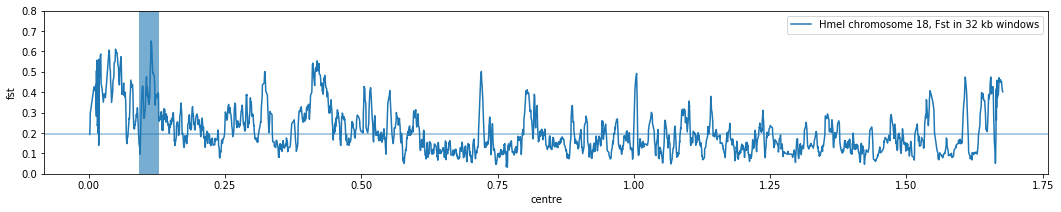

In [2]:
hmel18 = pd.read_csv('chrom18.csv')
hmel18.head()
genePos=(1058778+1159581)/2

fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(hmel18['centre']/10e6, hmel18['fst'],label='Hmel chromosome 18, Fst in 32 kb windows')
#horizontal line mean Fst with heterogeneity
plt.axvline(x=genePos/10e6, linewidth=20, alpha=0.6)
#add units for x-axis
plt.axhline(y=hmel18['fst'].mean(), alpha=0.5)
ax.set_ylim((0,0.8))
hmel18['fst'].mean()

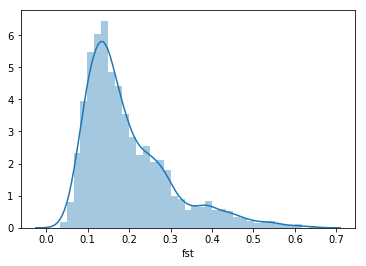

In [3]:
sns.distplot( hmel18['fst'], label='Fst in 32kb wins, n=20', norm_hist=True)

## 4. Recombination rate heterogeneity

We have so far ignored all sources of heterogeneity along the genome! An obvious source of heterogeneity is recombination. To explore the effect of this, we can condition simuations on an empricial distribution of recombination rates. heli_32kb_Davey2017_rec is a dataframe with recombination rates (cM/Mb) estimated in 32kb windows for both H. melpomene and H. cydno (Davey et al. 2017 generated three recombination maps for Hmel, Hcyd and interspecific F1). We will use the last column, which is the mean of these three maps:

You will notice that 32kb is the total length of sequence in a window after filtering (in this case only intergenic data). So windows have a span that is substantially longer than 32 kb.

- Using the postfiltering length rather than the span of windows is conservative: we are assuming a shorter map distance

- To make this more realistic one could bin windows by their span measured on the map.


Again, there are two ways of adding recombination heterogeneity into the simulations:
    
* simulate 32 kb windows, sampling from the list of recombination rates provided (which you will be doing)
* simulate a chunck of sequence with the actual recombination map (this bit is provided as a precooked dataset)

In [3]:
hapmap = pd.read_csv('heli_32kb_Davey2017_rec.csv', delimiter='\t')
hapmap.head()
#hapmap[hapmap['Chrom']==18]

,chrom,start,end,hmel,hcyd,f1,mean
0,1,66980,122860,1.6355,3.3415,1.5672,2.1814
1,1,122860,168185,1.6336,3.3067,1.7697,2.2367
2,1,168185,208610,1.6328,3.2851,1.9392,2.2857
3,1,208611,243766,1.6326,3.2541,2.0870,2.3246
4,1,243766,279430,1.6329,3.2302,2.2243,2.3624


median = 70.672kb


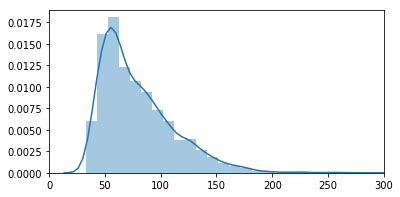

In [7]:
winspan=(hapmap['end']-hapmap['start'])/1000
fig, ax = plt.subplots(figsize=(6,3))
sns.distplot(winspan, label='window span')
ax.set_xlim((0, 300))
print("median = "+ str(winspan.median())+"kb")

The distribution of recombination rates across windows is wide and has a two modes. The lower is due to reduced $r$ around telomeres...

2.014522756706753


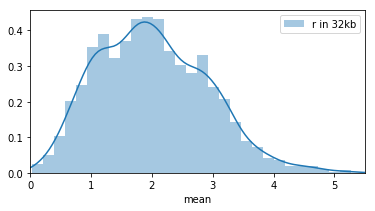

In [8]:
print(hapmap['mean'].mean()/2)
fig, ax = plt.subplots(figsize=(6,3))
sns.distplot(hapmap['mean']/2, label='r in 32kb')
ax.set_xlim((0, 5.5))
plt.legend()

### 4.1 Conditioning on a distribution of $r$

Draw a random sample from the empirical $r$ values for chromosome 18 and repeat the __msprime__ simulation (200 replicates) under the IM model:

In [ ]:
#simulate replicates with different recombination rates cfr. windows.
recomb = np.random.choice(hapmap[(hapmap['chrom']==18)]['mean']/2,size=num_reps)

Note that $r$ is in cM/Mb: to convert to recombination per base and generation, we need to divide by $10^{-8}$:

In [ ]:
demographic_events = [
    msprime.MassMigration(time=splitT, source=1, destination=0, proportion=1.0),
    ]

replicates_RecHet = [msprime.simulate(
        length = seqLength, 
        recombination_rate = rate/10e8,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        migration_matrix =  migration_matrix) for rate in recomb]

In [ ]:
# Fst_function (same function as in part1)
def Fst(ts):
    A = np.mean(ts.diversity([ts.get_samples(0), ts.get_samples(1)],mode='branch'))
    B = ts.divergence([ts.get_samples(0), ts.get_samples(1)],mode='branch')
    return (B-A)/(A+B)

In [ ]:
fstSims_RecHet = np.zeros(num_reps)
pop = list(range(0,nsamp*2))
p1, p2 = pop[:nsamp], pop[nsamp:]

for index, ts in enumerate(replicates_RecHet):
    fstSims_RecHet[index] = Fst(ts,samplesets=[p1,p2])[0]

$F_{st}$ has a much wider distribution if we include heterogeneity in $r$. The distribution of windowise $F_{st}$ under the IM history for _Heliconus melpomene_ and _H. cydno_ and the Heliconius recombination map for chromosome 18 is:

In [ ]:
#plot the outcome of your simulation runs
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(fstSims_RecHet, label='Fst in 32 kb, RecHet')
sns.distplot(fstSims, label='Fst in 32 kb, no RecHet')
sns.distplot(hmel18['fst'], label='Hmel Fst 32kb, n=10', norm_hist=True)
plt.legend()
ax.set_xlim((0, 0.5))

How do you use this distribution to determine outliers? 

The correct approach would be to bin windows by their span measured on the map, so you would then have a critical value for each of the different bins.

### 4.2 Conditioning simulations on the recombination map

Above we have drawn $r$ from its empirical distribution but simulated windows as independent. Ideally we would want to condition any outlier scan (critical values for $F_{st}$) on the $r$ in each window, or even better, condition on a recombination map. Let's use the first 8.5Mb of chromosome 18 as an example. Simulating an entire chromosomes is computationally costly, so we'll use pre-cooked simulations for this...

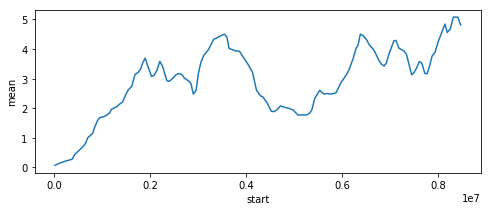

In [9]:
fig, ax = plt.subplots(figsize=(8,3))
sns.lineplot(
    data=hapmap[(hapmap['chrom']==18)&(hapmap['start']<8.5e6)],
    x = 'start',
    y = 'mean',
    legend=False,
    )

This loads two csv files each containing $F_{st}$ values in 32 kb windows for simulations either with or without heterogeneity in $r$:

In [7]:
dRecHet = pd.read_csv('n_10_RecHet_Fst.csv')
dNoRecHet = pd.read_csv('10Mb_sequence_data/win_largeFst.csv', index_col=0)
dRecHet.head()

,start,stop,Fst,replicate
0,0,32000,0.381300,0
1,6400,38400,0.343279,0
2,12800,44800,0.291818,0
3,19200,51200,0.284489,0
4,25600,57600,0.253204,0


We now plot one sliding window scan showing one replicate for both the simulations with and without heterogeneity in $r$.  

(0, 0.6)

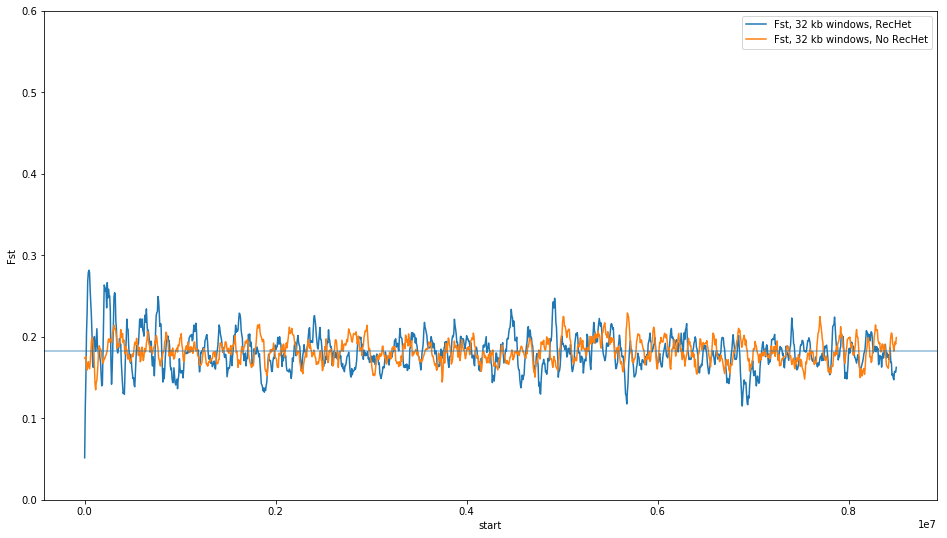

In [8]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(data=dRecHet[(dRecHet['replicate']==3)&(dRecHet['start']<8.5e6)],
             x ='start',
             y = 'Fst',
             label='Fst, 32 kb windows, RecHet')
sns.lineplot(data=dNoRecHet[(dNoRecHet['start']<8.5e6)],
             x ='start',
             y = 'Fst',
             label='Fst, 32 kb windows, No RecHet')
#horizontal line mean Fst with heterogeneity
plt.axhline(y=dNoRecHet['Fst'].mean(), alpha=0.5)
plt.legend()
ax.set_ylim((0,0.6))

When we now plot all 60 replicates with heterogeneity in $r$ we get a better feel for the variance in Fst along the sequence within regions of high/low recombination.

(-0.1, 0.7)

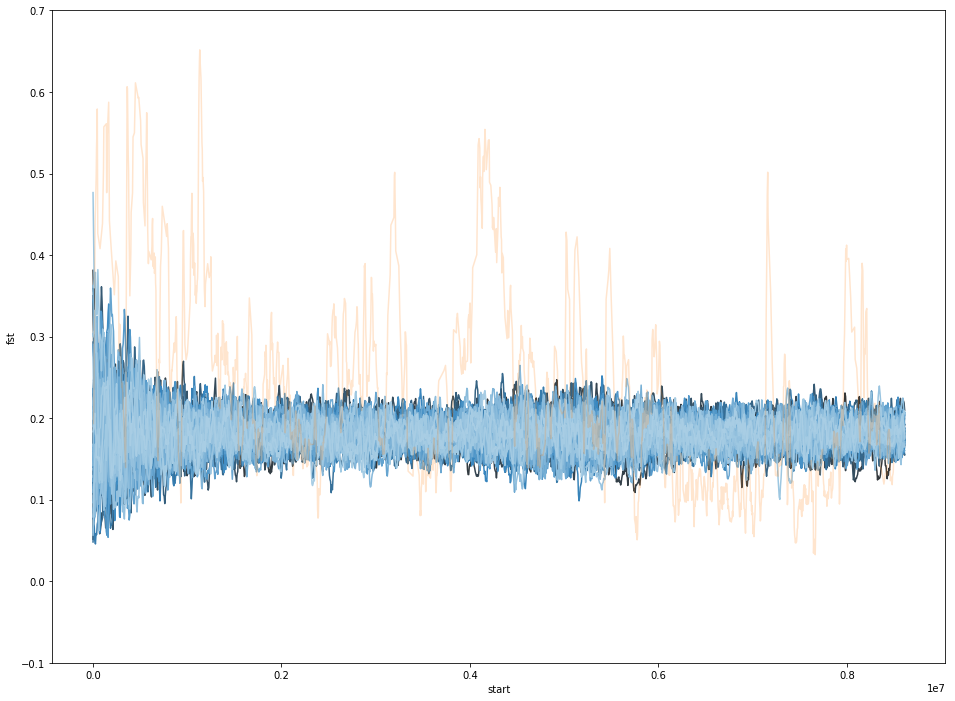

In [9]:
#60 of replicates 32kb windowise Fst scan with RecHet (at the moment samplesize = 5, haploid !!!!!)
fig, ax1 = plt.subplots(figsize=(16,12))

sns.lineplot(
    data=dRecHet,
    x = 'start',
    y = 'Fst',
    hue='replicate',
    estimator=None,
    palette = sns.color_palette('Blues_d', n_colors=60),
    legend=False,
    ax=ax1
    )
#overlay the empirical Fst distirbutions
sns.lineplot(
        data = hmel18[hmel18['start']<8.5e6],
    x = 'start',
    y = 'fst',
    ax = ax1,
    alpha=0.2
    )
ax1.set_ylim(-0.1, 0.7)

In [ ]:
hmel18.head()

## 5. Simulating selection

We have so far assumed selective neutraility. When adding selection into the mix, the distribution of all statistics of interest should get even closer to the observed real data. 

Unfortunately, to do so we can no longer rely on backwards-in-time simulators like __msprime__. However, selection can be implemented forwards in time using __SLiM__. We will use __SLiM__ only for the part of the history which we assume to be non-neutral in terms of the interaction between selection and the speciation process. 

Normally, forward simulations require a neutral burn-in period to allow for an equilibrium state of mutation-drift equlibrium (for neutral mutations) before the non-neutral dynamics take off. However, we can use the interface between __SLiM__ and __msprime__ to bolt on ("recapitate") the neutral part which is substantially faster.

(Because SLiM is not python based we won't be discussing the actual code although the code for the example we will be analysing is also provided as a seperate .txt file.)


Once you have written a forward-in-time simulation script, this is the workflow you should take:

* using SLiM output a .trees file containing the demographic history of all simulated individuals (of the last generation)
* recapitate (=add neutral dynamics to make sure all individuals you sample share one common ancestor) .trees by loading it using pyslim and msprime
* sprinkle neutral mutations along the treesequence
* analyse .trees file using tskit (or spit out a .vcf and use GiMBL)

(Good documentation is also provided in the SLiM manual and on https://pyslim.readthedocs.io/en/latest/)

### 5.1. a SLIM simulation example

* genome 8.5Mb (about half the size of chrom 18)
* all other (demographic) parameters as used above for the IM model
* 10 loci are randomly selected within a 32kb window positioned in the middle of the genome
* Each of these 10 loci has standing genetic variation within the ancestral population for one mutation per locus, at a starting frequency of 10%.
* Effect sizes are drawn from an exponential distribution exp(0.01).
* Similarly, 10 loci are selected within a 32kb window positioned at a quarter of the length of the genome.
* This time, effect sizes are drawn from exp(0.001).

In [13]:
one_RecHet_replicate = dRecHet[dRecHet['replicate']==np.random.randint(low=0, high=60)]
one_RecHet_replicate.drop(one_RecHet_replicate.columns[[-1]], axis=1, inplace=True)
selection = pd.read_csv('slim_Fst_100loci.csv', index_col=0)
sel_df = pd.concat([one_RecHet_replicate, selection])

/Users/s1854903/miniconda3/envs/slm/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


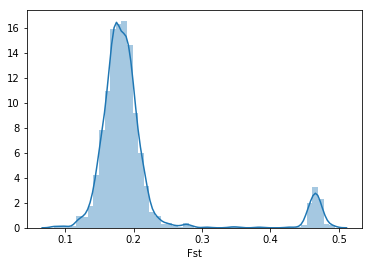

In [14]:
#if we want the plot not to be bimodal, we will have to run a bunch of replicates with selection 
# coeffients in between zero and the value I usede (exp(0.01), 100 loci)
sns.distplot(sel_df['Fst'])